# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   

# import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import ast
import re
from datetime import datetime, timedelta 
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/ta-datacsv/ta_data.csv
/kaggle/input/countries-of-the-world/countries of the world.csv
/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [4]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

### Добавил датасет из решения одного из участников соревнования

In [5]:
data_countries = pd.read_csv('/kaggle/input/countries-of-the-world/countries of the world.csv')

In [6]:
data_countries.sample(5)

,Country,Region,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),Phones (per 1000),Arable (%),Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service
174,St Pierre & Miquelon,NORTHERN AMERICA,7026,242,"29,0","49,59","-4,86","7,54",6900.0,"99,0","683,2","13,04",0,"86,96",NaN,"13,52","6,83",NaN,NaN,NaN
49,Cote d'Ivoire,SUB-SAHARAN AFRICA,17654843,322460,"54,8","0,16","-0,07","90,83",1400.0,"50,9","14,6","9,75","13,84","76,41",2,"35,11","14,84","0,279","0,171","0,55"
14,"Bahamas, The",LATIN AMER. & CARIB,303770,13940,"21,8","25,41","-2,2","25,21",16700.0,"95,6","460,6","0,8","0,4","98,8",2,"17,57","9,05","0,03","0,07","0,9"
176,Samoa,OCEANIA,176908,2944,"60,1","13,69","-11,7","27,71",5600.0,"99,7","75,2","21,2","24,38","54,42",2,"16,43","6,62","0,114","0,584","0,302"
202,Togo,SUB-SAHARAN AFRICA,5548702,56785,"97,7","0,10",0,"66,61",1500.0,"60,9","10,6","46,15","2,21","51,64",2,"37,01","9,83","0,395","0,204","0,401"


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [8]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [9]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [10]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [11]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [12]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [13]:
# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [14]:
# для удобства переименуем некоторые колонки
data.rename(
    columns={'Cuisine Style': 'Cuisine_Style', 'Price Range': 'Price_Range', 'Number of Reviews': 'Number_of_Reviews'}, inplace=True)

data.columns

Index(['Restaurant_id', 'City', 'Cuisine_Style', 'Ranking', 'Price_Range',
       'Number_of_Reviews', 'Reviews', 'URL_TA', 'ID_TA', 'sample', 'Rating'],
      dtype='object')

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine_Style        38410 non-null object
Ranking              50000 non-null float64
Price_Range          32639 non-null object
Number_of_Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [16]:
data.sample(5)

,Restaurant_id,City,Cuisine_Style,Ranking,Price_Range,Number_of_Reviews,Reviews,URL_TA,ID_TA,sample,Rating
38647,id_3171,Lisbon,['Italian'],3174.0,NaN,10.0,"[[], []]",/Restaurant_Review-g189158-d10403855-Reviews-C...,d10403855,1,3.5
28825,id_660,Edinburgh,"['Cafe', 'Mediterranean', 'Turkish', 'Vegan Op...",661.0,$,83.0,"[[""I'm a regular because it's great!"", 'Fringe...",/Restaurant_Review-g186525-d5850439-Reviews-Ol...,d5850439,1,4.5
39508,id_422,Ljubljana,"['European', 'Slovenian']",423.0,$$ - $$$,9.0,"[['Slovenian food', 'Good food, reasonable pri...",/Restaurant_Review-g274873-d13196545-Reviews-S...,d13196545,1,4.0
5222,id_5222,Rome,"['Italian', 'Mediterranean', 'Vegetarian Frien...",1641.0,$$ - $$$,276.0,"[['So Good!', 'Entertaining'], ['11/09/2017', ...",/Restaurant_Review-g187791-d1753728-Reviews-Ri...,d1753728,0,0.0
23419,id_1990,London,"['Cafe', 'British', 'Mediterranean', 'Turkish'...",1994.0,$,62.0,[['Great little cafe with wonderful home made....,/Restaurant_Review-g186338-d6654160-Reviews-Ol...,d6654160,1,5.0


In [17]:
data.Reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# Cleaning and Prepping Data
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.   
![](https://analyticsindiamag.com/wp-content/uploads/2018/01/data-cleaning.png)

## 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

In [18]:
# В столбце Reviews имеется 2 пропуска, посмотрим на остальные значения
data['Reviews']

0                                                 [[], []]
1        [['Very good reviews!', 'Fine dining in Hakani...
2        [['Better than the Links', 'Ivy Black'], ['12/...
3        [['Most exquisite', 'Delicious and authentic']...
4        [['Always the best in bratislava', 'Very good ...
                               ...                        
49995    [['The real Italian experience!', 'Wonderful f...
49996    [['Parisian atmosphere', 'Bit pricey but inter...
49997    [['Good by swedish standards', 'A hidden jewel...
49998    [['Underground restaurant', 'Oldest Restaurant...
49999    [['Average', 'Nice an informal'], ['01/31/2016...
Name: Reviews, Length: 50000, dtype: object

In [19]:
# Заменим пустые значения на аналогичные
data['Reviews'].fillna('[[], []]', inplace=True)

In [20]:
# Сохраним информацию о наблюдениях с пропусками
data['Number_of_Reviews_isNAN'] = pd.isna(
    data['Number_of_Reviews']).astype('uint8')
data['Cuisine_Style_isNAN'] = pd.isna(data['Cuisine_Style']).astype('uint8')
data['Price_Range_isNAN'] = pd.isna(data['Price_Range']).astype('uint8')

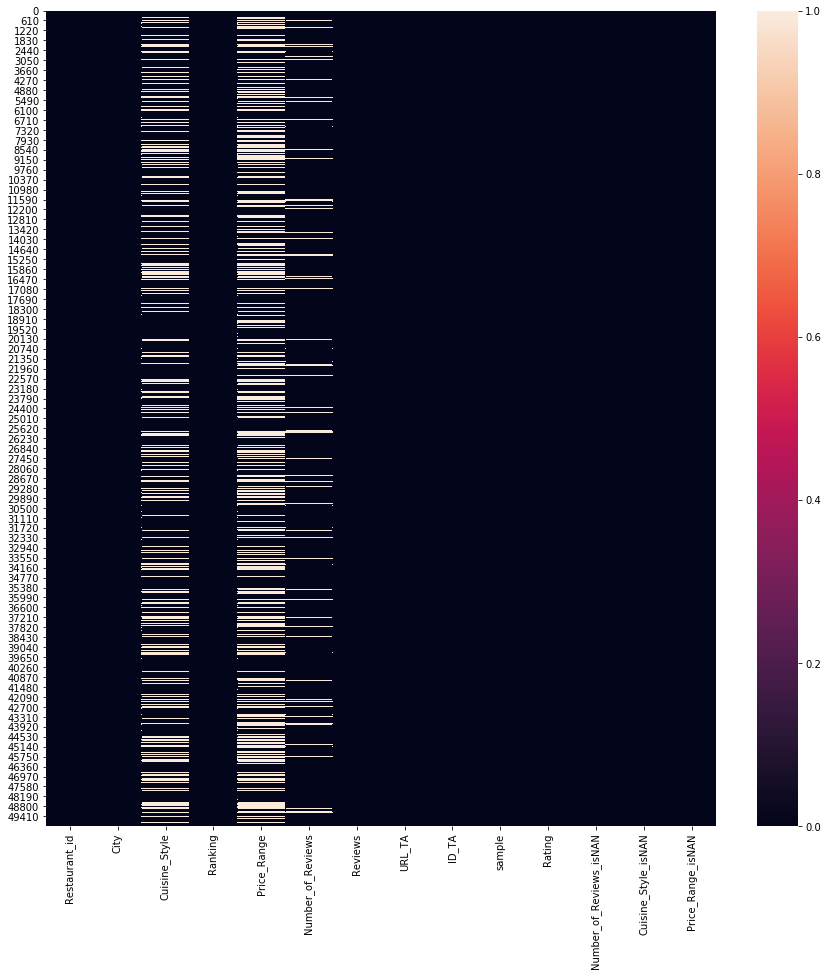

In [21]:
# Посмотрим визуально на наши пропуски
plt.subplots(figsize=(15, 15))
sns.heatmap(data.isnull())

In [22]:
# Заполним пропуски в столбце Number_of_Reviews на основании информации
# из стобца Reviews
def number_reviews(row):
    if pd.isnull(row.Number_of_Reviews):
        if len(row.Reviews) > 8:
            return 1
        return 0
    return row.Number_of_Reviews


# Применяем нашу функцию
data['Number_of_Reviews'] = data.apply(number_reviews, 1)

In [23]:
data['Number_of_Reviews'].value_counts()

2.0       2403
3.0       2042
0.0       2024
4.0       1707
5.0       1471
          ... 
1968.0       1
4738.0       1
2356.0       1
2006.0       1
1543.0       1
Name: Number_of_Reviews, Length: 1575, dtype: int64

In [24]:
# посмотрим на значения в столбце Price_Range
data['Price_Range'].value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price_Range, dtype: int64

In [25]:
# Самый распространённый средний ценовой сегмент, заполним пропуски им
data['Price_Range'].fillna('$$ - $$$', inplace=True)

In [26]:
# Пропуски в Cuisine_Style заменим на значение European
data.Cuisine_Style = data.Cuisine_Style.fillna(value='European')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 20 columns):
Country                               227 non-null object
Region                                227 non-null object
Population                            227 non-null int64
Area (sq. mi.)                        227 non-null int64
Pop. Density (per sq. mi.)            227 non-null object
Coastline (coast/area ratio)          227 non-null object
Net migration                         224 non-null object
Infant mortality (per 1000 births)    224 non-null object
GDP ($ per capita)                    226 non-null float64
Literacy (%)                          209 non-null object
Phones (per 1000)                     223 non-null object
Arable (%)                            225 non-null object
Crops (%)                             225 non-null object
Other (%)                             225 non-null object
Climate                               205 non-null object
Birthrate                 

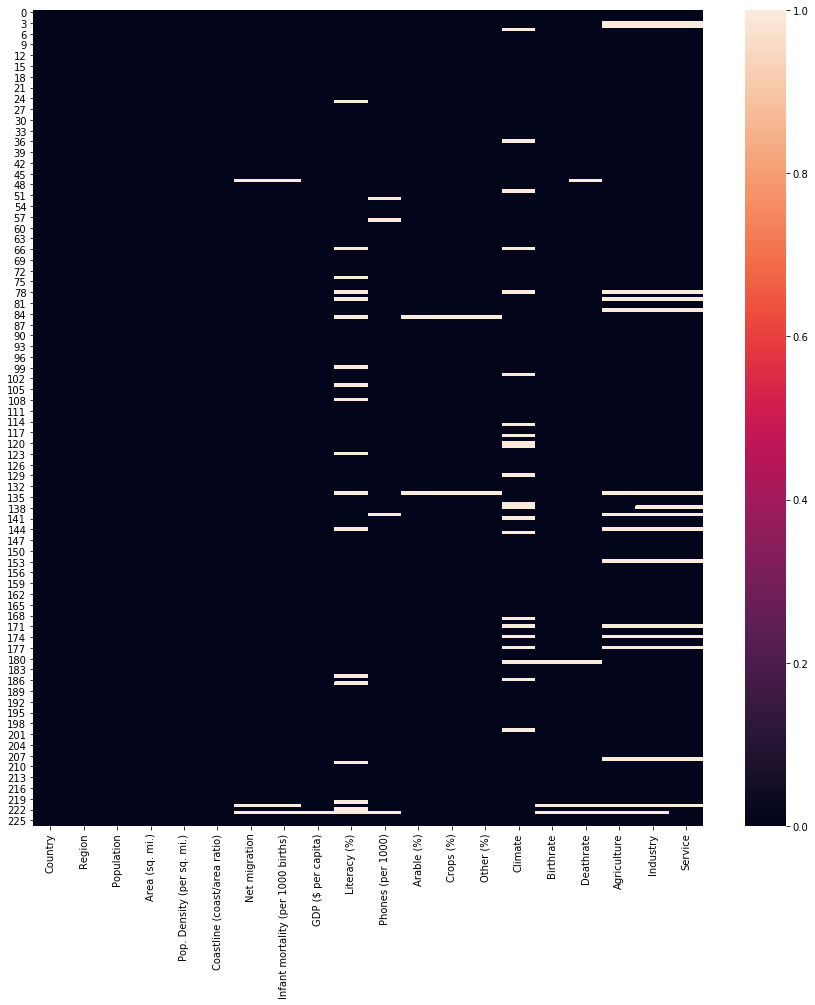

In [27]:
# Проверим пропуски в подгруженных датасетах
# Посмотрим визуально на наши пропуски
plt.subplots(figsize=(15, 15))
sns.heatmap(data_countries.isnull())
data_countries.info()

### 2. Обработка признаков
Для начала посмотрим какие признаки у нас могут быть категориальными.

In [28]:
data.nunique(dropna=False)

Restaurant_id              13094
City                          31
Cuisine_Style              10732
Ranking                    12975
Price_Range                    3
Number_of_Reviews           1575
Reviews                    41857
URL_TA                     49963
ID_TA                      49963
sample                         2
Rating                        10
Number_of_Reviews_isNAN        2
Cuisine_Style_isNAN            2
Price_Range_isNAN              2
dtype: int64

Какие признаки можно считать категориальными?

Для кодирования категориальных признаков есть множество подходов:
* Label Encoding
* One-Hot Encoding
* Target Encoding
* Hashing

Выбор кодирования зависит от признака и выбраной модели.
Не будем сейчас сильно погружаться в эту тематику, давайте посмотрим лучше пример с One-Hot Encoding:
![](https://i.imgur.com/mtimFxh.png)

## Пробежимся по всем признакам, а после закодируем наиболее успешные для нашей модели.

In [29]:
# посмотрим на признак Restaurant_id
data.Restaurant_id.value_counts()

id_633      19
id_436      19
id_227      19
id_871      19
id_344      18
            ..
id_11948     1
id_8708      1
id_10315     1
id_8134      1
id_6313      1
Name: Restaurant_id, Length: 13094, dtype: int64

In [30]:
# пропусков нет, значения повторяются, посмотрим какие данные у нас находятся под одним ID
data[data.Restaurant_id == 'id_227'].head(5)

,Restaurant_id,City,Cuisine_Style,Ranking,Price_Range,Number_of_Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Number_of_Reviews_isNAN,Cuisine_Style_isNAN,Price_Range_isNAN
227,id_227,Madrid,European,3208.0,$$ - $$$,23.0,"[['40th', 'The Center of Spain'], ['07/23/2017...",/Restaurant_Review-g187514-d10040653-Reviews-P...,d10040653,0,0.0,0,1,1
11065,id_227,Luxembourg,"['Lebanese', 'Mediterranean', 'Middle Eastern'...",228.0,$$ - $$$,21.0,"[['Nice little Lebanese restaurant', 'Great fo...",/Restaurant_Review-g190356-d10275783-Reviews-K...,d10275783,1,4.0,0,0,0
14727,id_227,Bratislava,"['Healthy', 'European', 'Mediterranean', 'Vege...",228.0,$$ - $$$,122.0,"[['Great fish (African sharptooth catfish)', '...",/Restaurant_Review-g274924-d4009959-Reviews-Me...,d4009959,1,4.0,0,0,0
16237,id_227,Athens,"['European', 'Greek', 'Mediterranean']",228.0,$$ - $$$,220.0,"[['Spectacular view and food', 'Great view'], ...",/Restaurant_Review-g189400-d1898490-Reviews-Ol...,d1898490,1,4.5,0,0,0
17521,id_227,Warsaw,"['Polish', 'European', 'Central European', 'Ea...",228.0,$$ - $$$,95.0,"[['Great place', 'A lovely warm place and good...",/Restaurant_Review-g274856-d2410632-Reviews-Fe...,d2410632,1,4.0,0,0,0


In [31]:
# с признаком Restaurant_id не придумал что делать,
# из признака Restaurant_id оставил числовую часть
data['Restaurant_id_Code'] = data['Restaurant_id'].apply(lambda x: int(x[3:]))

# Поработаем с признаком City, добавим по нему новые признаки

In [32]:
# Введём признак, является ли город столицей
capital = ['Amsterdam', 'Athens', 'Berlin', 'Bratislava', 'Brussels', 'Budapest', 'Copenhagen', 'Dublin', 'Edinburgh', 'Helsinki',
           'Lisbon', 'Ljubljana', 'London', 'Luxembourg', 'Madrid', 'Oslo', 'Paris', 'Prague', 'Rome', 'Stockholm', 'Vienna', 'Warsaw']
data['Capital'] = data['City'].apply(lambda x: 1 if x in (capital) else 0)

In [33]:
# Признак Capital положительно влияет на оценку обучаемости нашей модели если воспользоваться One-Hot Encoding
data = pd.get_dummies(data, columns=['Capital'], dummy_na=False)

In [34]:
# Добавим признак принадлежности к стране
city_country = {
    'London': 'United Kingdom ',
    'Paris': 'France ',
    'Madrid': 'Spain ',
    'Barcelona': 'Spain ',
    'Berlin': 'Germany ',
    'Milan': 'Italy ',
    'Rome': 'Italy ',
    'Prague': 'Czech Republic ',
    'Lisbon': 'Portugal ',
    'Vienna': 'Austria ',
    'Amsterdam': 'Netherlands ',
    'Brussels': 'Belgium ',
    'Hamburg': 'Germany ',
    'Munich': 'Germany ',
    'Lyon': 'France ',
    'Stockholm': 'Sweden ',
    'Budapest': 'Hungary ',
    'Warsaw': 'Poland ',
    'Dublin': 'Ireland ',
    'Copenhagen': 'Denmark ',
    'Athens': 'Greece ',
    'Edinburgh': 'Schotland ',
    'Zurich': 'Switzerland ',
    'Oporto': 'Portugal ',
    'Geneva': 'Switzerland ',
    'Krakow': 'Poland ',
    'Oslo': 'Norway ',
    'Helsinki': 'Finland ',
    'Bratislava': 'Slovakia ',
    'Luxembourg': 'Luxembourg ',
    'Ljubljana': 'Slovenia '
}

data['Country'] = data['City'].map(city_country)

In [35]:
# Для признака Country воспользуемся LabelEncoder
# пробовал One-Hot Encoding - оценка хуже
countries_le = LabelEncoder()
countries_le.fit(data['Country'])
data['Country_Code'] = countries_le.transform(data['Country'])

In [36]:
# Добавим численность населения агломерации из Wiki
city_population = {'London': 10979, 'Paris': 11020, 'Madrid': 6026, 'Barcelona': 4588,
                   'Berlin': 6177, 'Milan': 4907, 'Rome': 3900, 'Prague': 1308,
                   'Lisbon': 2942, 'Vienna': 2300, 'Amsterdam': 2400, 'Brussels': 1831,
                   'Hamburg': 1841, 'Munich': 1471, 'Lyon': 1748, 'Stockholm': 2352,
                   'Budapest': 2965, 'Warsaw': 3100, 'Dublin': 1347,
                   'Copenhagen': 1308, 'Athens': 3168, 'Edinburgh': 513,
                   'Zurich': 1334, 'Oporto': 1313, 'Geneva': 496, 'Krakow': 1200,
                   'Oslo': 1558, 'Helsinki': 1299, 'Bratislava': 700,
                   'Luxembourg': 626, 'Ljubljana': 508}
data['Сity_population'] = data.apply(
    lambda row: city_population[row['City']], axis=1)

In [37]:
# Добавим численность населения страны из датасета
data['Country_population'] = data['Country'].map(data_countries.groupby('Country')['Population'].sum())
# Добавим численность населения Шотландии, потому что в загруженном датасете нет информации по этой стране
data['Country_population'] = data['Country_population'].fillna(5454000)

In [38]:
#Добавим столбец с разделением городов по частям Европы
west_europe = ['London','Berlin','Paris','Zurich','Vienna','Amsterdam','Brussels','Humburg',
               'Munich','Lyon','Dublin','Edinburgh','Geneva','Luxembourg']
north_europe = ['Copenhagen','Helsinki','Oslo','Stockholm']
east_europe = ['Prague','Bratislava','Budapest','Krakow','Warsaw']
south_europe = ['Barcelona','Ljubljana','Madrid','Milan','Oporto','Rome','Athens','Lisbon']

def part_europe(x):
    if x in west_europe:
        return 0
    elif x in south_europe:
        return 1
    elif x in north_europe:
        return 2
    else:
        return 3
    
data['europe_part'] = data['City'].apply(part_europe)
#Попробуем one-hot encoding для этого признака (модель работает лучше)
data = pd.get_dummies(data, columns=['europe_part'], dummy_na=False)

In [39]:
#Теперь добавим минимальные зарплаты в зависимости от страны в евро
country_salary = {
    'France ': 1539.42, 'Finland ': 1211, 'Schotland ': 1524.76, 'United Kingdom ': 1598.69, 'Slovakia ': 580, 
    'Portugal ': 740.83, 'Hungary ': 487.10, 'Sweden ': 2000, 'Italy ': 700,
    'Germany ': 1584, 'Czech Republic ': 574.62, 'Austria ': 1360,'Ireland ': 1656.2, 'Spain ': 1050,
    'Belgium ': 1593.81, 'Norway ': 2751.50, 'Netherlands ': 1635.6, 'Greece ': 758.33,
    'Poland ': 610.79, 'Denmark ':  2476, 'Luxembourg ': 2141.99, 'Switzerland ': 2538.59, 'Slovenia ': 940.58
}
data['Country_minsalary'] = data['Country'].map(country_salary)
data['Country_minsalary']

0        1539.42
1        1211.00
2        1524.76
3        1598.69
4         580.00
          ...   
49995     700.00
49996    1539.42
49997    2000.00
49998     610.79
49999     700.00
Name: Country_minsalary, Length: 50000, dtype: float64

In [40]:
# Добавим признак по количеству ресторанов в городе
# Создадим справочник с указанием количества ресторанов для каждого города, присутствующего в датасете
restaurant_stat_data = {
    'Paris': 17593,
    'Stockholm': 3131,
    'London': 22366,
    'Berlin': 8110,
    'Munich': 3367,
    'Oporto': 2060,
    'Milan': 7940,
    'Bratislava': 1331,
    'Vienna': 4387,
    'Rome': 12086,
    'Barcelona': 10086,
    'Madrid': 11562,
    'Dublin': 2706,
    'Brussels': 3703,
    'Zurich': 1901,
    'Warsaw': 3210,
    'Budapest': 3445,
    'Copenhagen': 2637,
    'Amsterdam': 4189,
    'Lyon': 2833,
    'Hamburg': 3501,
    'Lisbon': 4985,
    'Prague': 5850,
    'Oslo': 1441,
    'Helsinki': 1661,
    'Edinburgh': 2248,
    'Geneva': 1753,
    'Ljubljana': 647,
    'Athens': 2814,
    'Luxembourg': 759,
    'Krakow': 1832
}
data['Restaurant_count'] = data['City'].map(restaurant_stat_data)

In [41]:
# Добавим признак - количество ресторанов на квадратный метр города
# для этого сначала создадим справочник для площадей городов
city_square = {
    'Paris': 105.4,
    'Stockholm': 188,
    'London': 1572,
    'Berlin': 891.8,
    'Munich': 310.7,
    'Oporto': 41.42,
    'Milan': 181.8,
    'Bratislava': 367.6,
    'Vienna': 414.6,
    'Rome': 1285,
    'Barcelona': 101.9,
    'Madrid': 604.3,
    'Dublin': 117.8,
    'Brussels': 32.61,
    'Zurich': 87.88,
    'Warsaw': 517.2,
    'Budapest': 525.2,
    'Copenhagen': 88.25,
    'Amsterdam': 219.3,
    'Lyon': 47.87,
    'Hamburg': 755.2,
    'Lisbon': 100,
    'Prague': 496,
    'Oslo': 454,
    'Helsinki': 213.8,
    'Edinburgh': 264,
    'Geneva': 15.93,
    'Ljubljana': 163.8,
    'Athens': 38.96,
    'Luxembourg': 51.46,
    'Krakow': 327
}
data['City_square'] = data['City'].map(city_square)

In [42]:
# Добавим признак по количеству ресторанов на км в городе
data['Rests_per_km'] = data['Restaurant_count'] / data['City_square']

In [43]:
# добавим признак с количеством ресторанов с различными рейтингами от 1 до 5
# разделим рестораны на категории 1 - [1:3), 2 - [3:4), 3 - [4:5]
count_rat1_rests = {}
for i in data['City'][(data['Rating'] >= 1) & (data['Rating'] < 3)].value_counts().index:
    count_rat1_rests[i] = data['City'][(data['Rating'] >= 1) & (data['Rating'] < 3)].value_counts()[i]

data['rests_rating1_count'] = data['City'].map(count_rat1_rests)

In [44]:
# 2 категория
count_rat2_rests = {}
for i in data['City'][(data['Rating'] >= 3) & (data['Rating'] < 4)].value_counts().index:
    count_rat2_rests[i] = data['City'][(data['Rating'] >= 3) & (data['Rating'] < 4)].value_counts()[i]

data['rests_rating2_count'] = data['City'].map(count_rat2_rests)

In [45]:
# 3 категория
count_rat3_rests = {}
for i in data['City'][data['Rating'] >= 4].value_counts().index:
    count_rat3_rests[i] = data['City'][data['Rating'] >= 4].value_counts()[i]

data['rests_rating3_count'] = data['City'].map(count_rat3_rests)

In [46]:
# Заменим пропуски в 3 категориях на ноль
data['rests_rating1_count'] = data['rests_rating1_count'].fillna(0)
data['rests_rating2_count'] = data['rests_rating2_count'].fillna(0)
data['rests_rating3_count'] = data['rests_rating3_count'].fillna(0)

#### Возьмем следующий признак Cuisine_Style

In [47]:
# теперь поработаем с кухнями
# сделаем, чтобы читалось как список
data['Cuisine_Style'] = data['Cuisine_Style'].str[2:-2].str.split("', '")

In [48]:
# сгенерируем новый признак кол-во кухонь в ресторане
data['Cuisine_Style_count'] = data['Cuisine_Style'].str.len()

In [49]:
# среднее количество кухонь предлагаемых в одном ресторане
data['Cuisine_Style_count'].mean()

2.62532

#### Добавим признак с наличием некоторых блюд

In [50]:
# Создадим список кухонб датасета и выберем из них топ-10
cuis_list = []
for i in data['Cuisine_Style'][(data['Rating'] < 3.5) & (data['Rating'] > 4.5)]:
    for u in i:
        cuis_list.append(u)
        
top_cuisines = pd.Series(cuis_list).value_counts()[:10]

In [51]:
# Применим к нашему датасету топ-10 и добавим признаких с информацией о наличии таких кухонб в ресторане
for cuisine_style in top_cuisines.index:
    data[cuisine_style] = data['Cuisine_Style'].apply(lambda x: 1 if cuisine_style in x else 0)

In [52]:
# Добавим признак к информацией по среднему количеству кухонь в ресторанах в городе
data['Cuisines_in_City'] = data['City'].map(data.groupby('City')['Cuisine_Style_count'].mean())

Все остальные созданные признаки Cuisine style

#### Возьмем следующий признак "Price Range".

In [53]:
data['Price_Range'].value_counts()

$$ - $$$    40402
$            7816
$$$$         1782
Name: Price_Range, dtype: int64

По описанию 'Price Range' это - Цены в ресторане.  
Их можно поставить по возрастанию (значит это не категориальный признак). А это значит, что их можно заменить последовательными числами, например 1,2,3  
*Попробуйте сделать обработку этого признака уже самостоятельно!*

In [54]:
# Ваша обработка 'Price Range'
# создадим словарь и подставим значения из него
price_range_dict = {'$': 0, '$$ - $$$': 1, '$$$$': 2}
data = data.replace({'Price_Range': price_range_dict})

In [55]:
# Средняя цена в городе

data['Price_in_City'] = data['City'].map(data.groupby('City')['Price_Range'].mean())

In [56]:
# Оценка модели лучше, если закодировать признак с One-Hot Encoding
data = pd.get_dummies(data, columns=['Price_Range'], dummy_na=False)

#### Перейдем к признаку Ranking

In [57]:
# Теперь подробно остановимся на признаке Ranking и попробуем выжать максимум
# Пересчитаем относительно максимального значения в городе
data['Ranking_city'] = data['Ranking'] / \
   data['City'].map(data.groupby(['City'])['Ranking'].max())

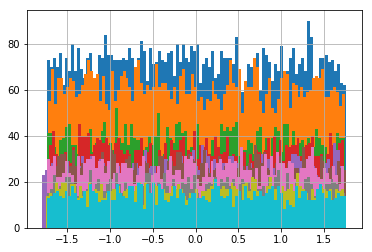

In [58]:
# Теперь попробуем нормализовать и посмотрим визуально
data['Ranking_normalized'] = data.groupby(
    'City')['Ranking'].transform(lambda x: (x-x.mean())/x.std())

for x in (data['City'].value_counts())[0:10].index:
    data['Ranking_normalized'][data['City'] == x].hist(bins=100)
plt.show()

In [59]:
# Теперь относительно количества ресторанов
data['Ranking_Res'] = data['Ranking'] / data['Restaurant_count']

In [60]:
#Теперь попробуем сделать категории с помощью Ranking_avg: 0 - если больше среднего Ranking и 1 - если больше
Ranking_avg = data.groupby(
    'City')['Ranking'].transform(lambda x: x.mean())

data['Ranking_cat'] = data['Ranking'].apply(lambda x: 1 if x <= Ranking_avg.loc[x] else 0)
# Оценка модели лучше, если закодировать признак с One-Hot Encoding
data = pd.get_dummies(data, columns=['Ranking_cat'], dummy_na=False)

In [61]:
# Добавим признак средний ранк по городу
data['Rank_avg'] = data['City'].map(data.groupby('City')['Ranking'].mean())

#### Переходим к признаку Number of Reviews

In [62]:
# Попробуем нормализовать признак Number_of_Reviews
data['NoR_normalized'] = data.Number_of_Reviews.transform(lambda x: (x-x.mean())/x.std())

In [63]:
# добавим признак - кол-во отзывов пропорционально кол-ву жителей
data['Number_of_Reviews_city'] = data['Number_of_Reviews']/data['Сity_population']

In [64]:
NoR_sum = data.groupby('City')['Number_of_Reviews'].sum()

data['NoR_inCity'] = data['City'].map(NoR_sum) / data['Сity_population']

#### Теперь поработаем с самым засоренным признаком Reviews

In [65]:
def return_review_date(row, mode='newest'):
    str_review = ast.literal_eval(str(row['Reviews']).replace('nan', '0'))
    if str_review == [[], []]:
        return 'NaN'
    elif len(str_review[1]) == 1:
        return(datetime.strptime(str_review[1][0], '%m/%d/%Y'))
    else:
        first_review_time = datetime.strptime(str_review[1][0], '%m/%d/%Y')
        second_review_time = datetime.strptime(str_review[1][1], '%m/%d/%Y')
        if mode == 'newest':
            return max(second_review_time, first_review_time)
        else:
            return min(second_review_time, first_review_time)

# заполним даты отзывов


data['newest_review_date'] = data.apply(
    lambda row: return_review_date(row, mode='newest'), axis=1)
data['eldest_review_date'] = data.apply(
    lambda row: return_review_date(row, mode='eldest'), axis=1)

In [66]:
# создадим признак для ресторанов, у которых нет отзывов
data['is_nan_reviews'] = pd.isna(data['newest_review_date']).astype('float64')

In [67]:
# посмотрим на дату самого свежего отзыва
newest_review_date = data['newest_review_date'].max()
newest_review_date

Timestamp('2018-02-26 00:00:00')

In [68]:
# посмотрим на дату самого старого отзыва
oldest_review_date = data['eldest_review_date'].min()
oldest_review_date

Timestamp('2004-04-21 00:00:00')

In [69]:
# для ресторанов без отзывов добавим минимальную дату
data['newest_review_date'].fillna(oldest_review_date, inplace=True)
data['eldest_review_date'].fillna(oldest_review_date, inplace=True)

In [70]:
# Посчитаем разницу в днях между отзывами
data['days_to_most_recent_review'] = (
    newest_review_date - data['newest_review_date']).dt.days
data['days_between_oldest_newest_reviews'] = (
    data['newest_review_date'] - data['eldest_review_date']).dt.days

In [71]:
# Нормализуем разницу в днях между отзывами
data['days_to_most_recent_review_norm'] = data['days_to_most_recent_review'].apply(
        lambda x: (x-data['days_to_most_recent_review'].mean())/data['days_to_most_recent_review'].std())

In [72]:
# Создадим признаки с наличием хороших отзывов в признаке Reviews
def good_words(data):
    
    check_words_1 = ['well', 'good', 'excellent', 'best', 'brilliant', 'incredible', 'amazing', 'a-mazing',
                   'friendly', 'nice', 'ok', 'great', 'lovely', 'fantastic', 'enjoy', 'tasty', 'cool',
                   'cozy','perfect','convenient','perfection','delicious', 'pretty good','delightful']

    for word in check_words_1:
        data[word] = 0
        for i in range(len(data)):
            if word in data['Reviews'][i].lower() and 'not' not in data['Reviews'][i].lower():
                data.loc[i, word] = 1


good_words(data)

In [73]:
# Создадим признак с количеством хороших слов в каждом Reviews
check_words_1 = ['well', 'good', 'excellent', 'best', 'brilliant', 'incredible', 'amazing', 'a-mazing',
                   'friendly', 'nice', 'ok', 'great', 'lovely', 'fantastic', 'enjoy', 'tasty', 'cool',
                   'cozy','perfect','convenient','perfection','delicious', 'pretty good','delightful']

def count_good_words(row):
    for good_word in check_words_1:
        cnt = 0
        if good_word in row.lower() and 'not' not in row.lower():
            cnt += 1

data['good_words_count'] = data['Reviews'].apply(count_good_words)

In [74]:
# Создадим признак с количеством плохих слов в каждом Reviews
check_words_2 = ['poor', 'bad', 'worse', 'but', 'no good', 'slow','awful','meh','slow',
                  'terrible','expensive']

def count_bad_words(row):
    for bad_word in check_words_2:
        cnt = 0
        if bad_word in row.lower() and 'not' not in row.lower():
            cnt += 1
            
data['bad_words_count'] = data['Reviews'].apply(count_bad_words)

#### Добавим ID_TA_code

In [75]:
# из признака ID_TA оставил числовую часть, если убрать совсем оценка становится хуже
data['ID_TA_Code'] = data['ID_TA'].apply(lambda x: int(x[1:]))

In [76]:
data.ID_TA.nunique()

49963

### С признаком URL_TA ничего не получилось сделать. Парсинг занимает очень много времени, поэтому не получилось использовать

#### Посмотрим на загруженные датасеты и добавим новые признаки
###### Оставил два признака coastline и gdp_country, они единственные хорошо влияют на MAE

In [77]:
data['coastline'] = data['Country'].map(data_countries.groupby('Country')['Coastline (coast/area ratio)'].sum())
# Заменим все пустые значени в данном столбце на значение признака по стране United Kingdom
data['coastline'] = data['coastline'].fillna('5,08')
data['coastline'] = data['coastline'].apply(lambda x: float(str(x).replace(",",".")))

In [78]:
data['gdp_country'] = data['Country'].map(data_countries.groupby('Country')['GDP ($ per capita)'].sum())
# Заменим все пустые значени в данном столбце на значение признака по стране United Kingdom
data['gdp_country'] = data['gdp_country'].fillna(27700.0)
data['gdp_country'] = data['gdp_country'].apply(lambda x: float(str(x).replace(",",".")))

In [79]:
# закодируем City
data = pd.get_dummies(data, columns=['City'], dummy_na=False)

# EDA 
[Exploratory Data Analysis](https://ru.wikipedia.org/wiki/Разведочный_анализ_данных) - Анализ данных
На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками.
В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой.
Понимание изначальных признаков позволит сгенерировать новые, более сильные и, тем самым, сделать нашу модель лучше.

### Посмотрим распределение признака

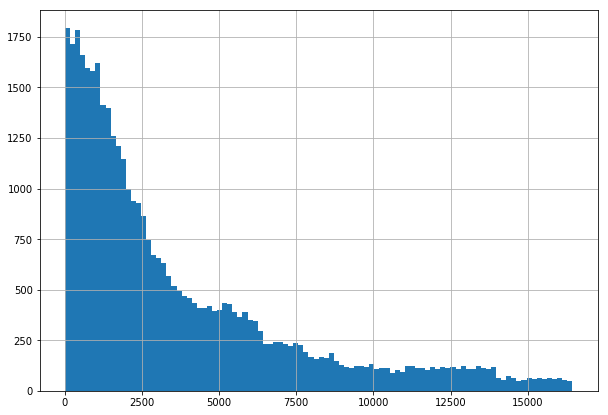

In [80]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

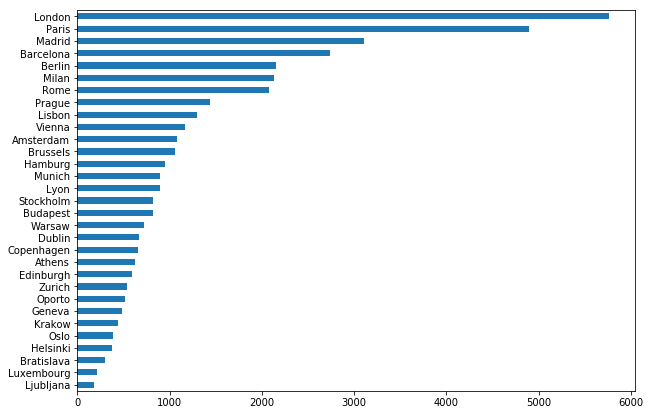

In [81]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

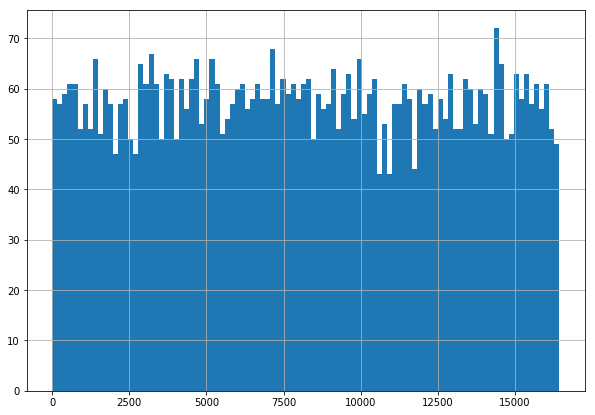

In [82]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

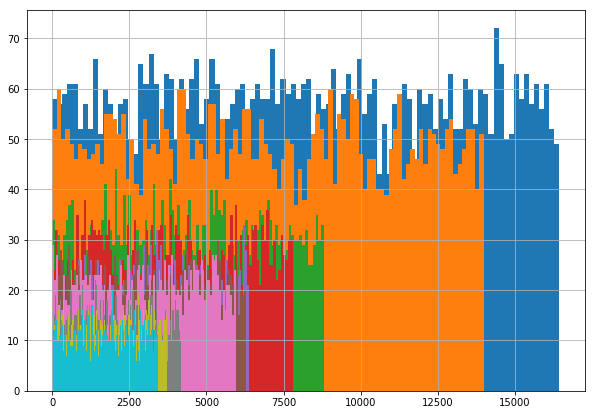

In [83]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

### Посмотрим распределение целевой переменной

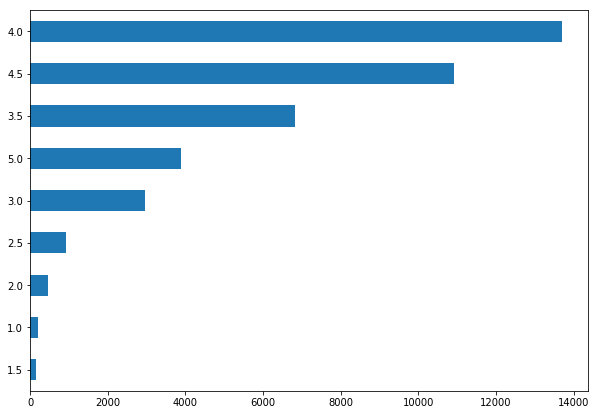

In [84]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

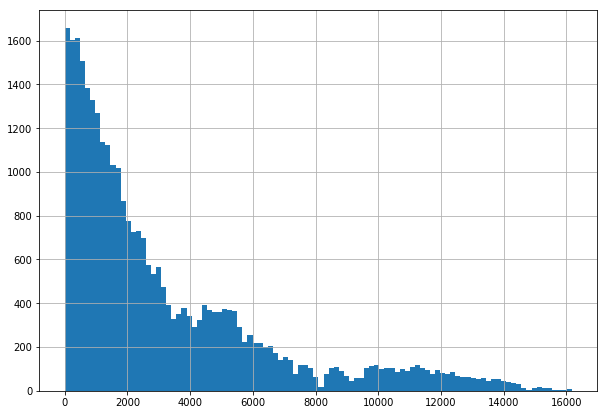

In [85]:
df_train['Ranking'][(df_train['Rating'] >= 3.5) & (df_train['Rating'] < 5)].hist(bins=100)

### Посмотрим распределение целевой переменной относительно признака

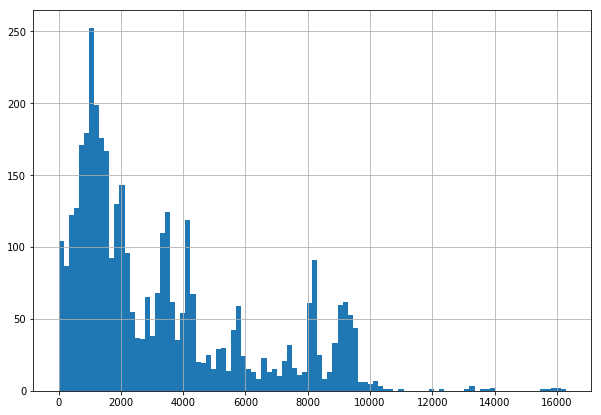

In [86]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

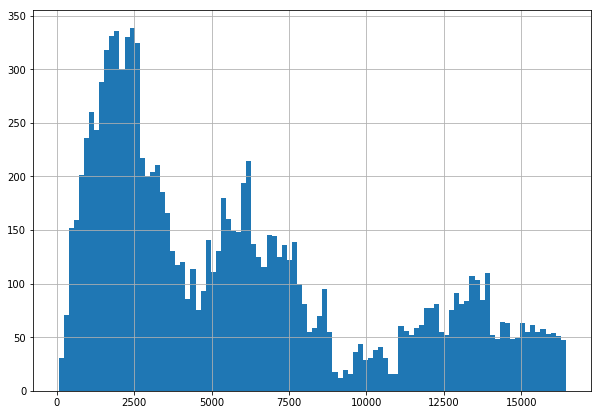

In [87]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

### И один из моих любимых - [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

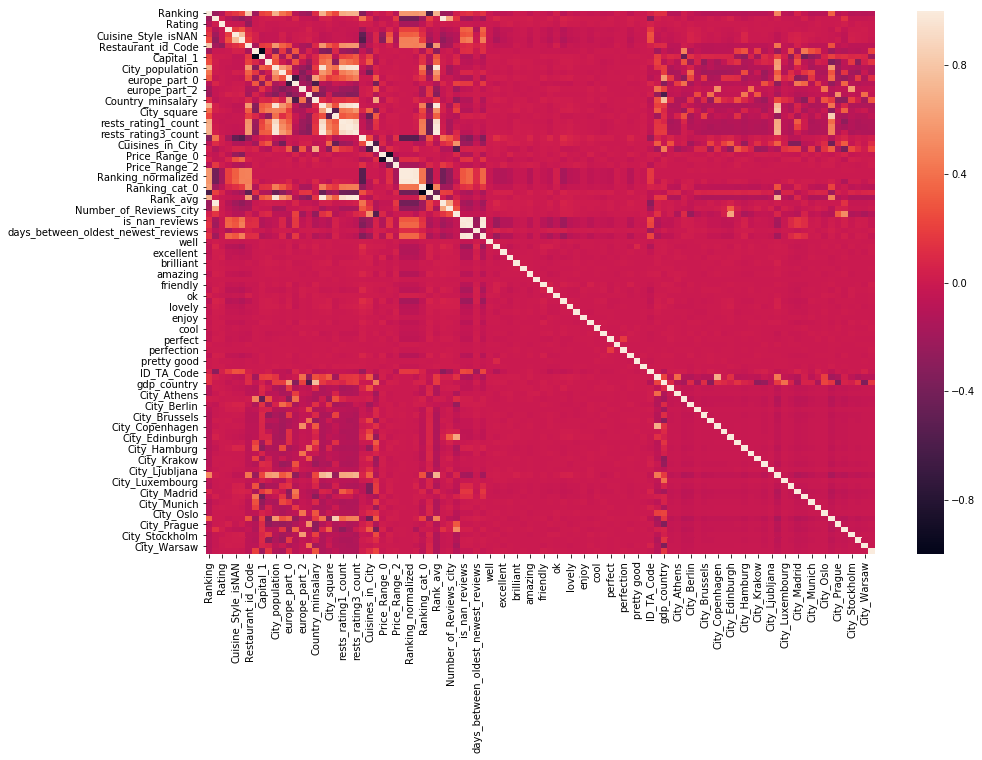

In [88]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

Вообще благодаря визуализации в этом датасете можно узнать много интересных фактов, например:
* где больше Пицерий в Мадриде или Лондоне?
* в каком городе кухня ресторанов более разнообразна?

придумайте свои вопрос и найдите на него ответ в данных)

# Data Preprocessing

In [89]:
# очищаем наши данные от личшнего
df_preproc = data.copy()
df_preproc.drop(['Restaurant_id', 'ID_TA', ], axis=1, inplace=True)
df_preproc = df_preproc.select_dtypes(exclude=['object', 'datetime64[ns]'])

#### Запускаем и проверяем что получилось

In [90]:
df_preproc.sample(10)

,Ranking,Number_of_Reviews,sample,Rating,Number_of_Reviews_isNAN,Cuisine_Style_isNAN,Price_Range_isNAN,Restaurant_id_Code,Capital_0,Capital_1,...,City_Munich,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich
21961,6957.0,30.0,1,4.5,0,0,0,6948,0,1,...,0,0,0,0,0,0,0,0,0,0
32897,397.0,481.0,1,4.0,0,0,0,396,1,0,...,0,1,0,0,0,0,0,0,0,0
9505,1324.0,4.0,0,0.0,0,1,1,9505,0,1,...,0,0,0,0,0,0,1,0,0,0
5308,13003.0,3.0,0,0.0,0,1,1,5308,0,1,...,0,0,0,1,0,0,0,0,0,0
16920,5069.0,33.0,1,4.5,0,1,1,5068,0,1,...,0,0,0,1,0,0,0,0,0,0
34626,2354.0,20.0,1,4.0,0,1,1,2352,0,1,...,0,0,0,0,0,0,0,0,0,0
21573,1122.0,5.0,1,4.5,0,1,1,1121,0,1,...,0,0,0,0,0,0,0,0,0,0
9595,419.0,5.0,0,0.0,0,0,0,9595,0,1,...,0,0,0,0,0,0,0,0,0,0
26220,5141.0,9.0,1,4.0,0,0,0,5140,1,0,...,0,0,0,0,0,0,0,0,0,0
34047,4318.0,3.0,1,4.5,0,1,1,4316,0,1,...,0,0,0,0,0,0,0,0,0,0


In [91]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 101 entries, Ranking to City_Zurich
dtypes: float64(21), int64(35), uint8(45)
memory usage: 23.5 MB


In [92]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [93]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [94]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 100), (40000, 100), (40000, 99), (32000, 99), (8000, 99))

# Model 
Сам ML

In [95]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [96]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [97]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   20.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [98]:
# Если посмотреть на получившиеся данные, заметим, что числа не кратны 0.5,
y_pred

array([4.46 , 4.89 , 4.25 , ..., 4.65 , 4.225, 4.07 ])

In [99]:
# округлим данные
# Округляем результаты с точностью 0.5

def rating_round(x, base=0.5):
    return base * round(x/base)

def predict(ds):
    return np.array([rating_round(x) for x in model.predict(ds)])

y_pred = predict(X_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [100]:
y_pred

array([4.5, 5. , 4. , ..., 4.5, 4. , 4. ])

In [101]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.162


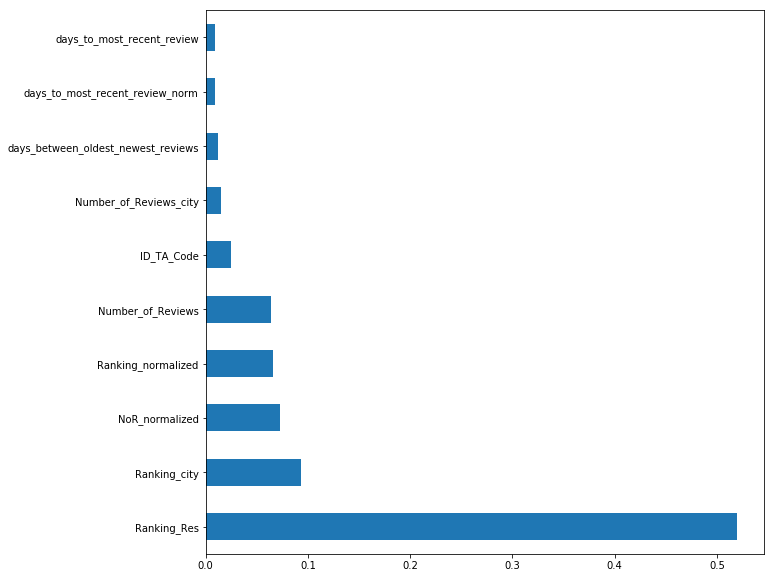

In [102]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [103]:
test_data.sample(10)

,Ranking,Number_of_Reviews,Rating,Number_of_Reviews_isNAN,Cuisine_Style_isNAN,Price_Range_isNAN,Restaurant_id_Code,Capital_0,Capital_1,Country_Code,...,City_Munich,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich
6452,15635.0,15.0,0.0,0,0,1,6452,0,1,22,...,0,0,0,0,0,0,0,0,0,0
8939,2398.0,13.0,0.0,0,1,1,8939,1,0,5,...,0,0,0,0,0,0,0,0,0,0
6410,12067.0,2.0,0.0,0,1,1,6410,0,1,5,...,0,0,0,1,0,0,0,0,0,0
3822,6804.0,15.0,0.0,0,0,0,3822,0,1,22,...,0,0,0,0,0,0,0,0,0,0
4830,1435.0,32.0,0.0,0,0,0,4830,0,1,14,...,0,0,0,0,0,0,0,0,1,0
776,1722.0,4.0,0.0,0,0,1,776,0,1,3,...,0,0,0,0,0,0,0,0,0,0
23,1255.0,51.0,0.0,0,0,0,23,0,1,1,...,0,0,0,0,0,0,0,0,0,0
540,1509.0,24.0,0.0,0,0,0,540,0,1,20,...,0,0,0,0,0,0,1,0,0,0
5819,556.0,61.0,0.0,0,0,0,5819,1,0,5,...,0,0,0,0,0,0,0,0,0,0
1636,2477.0,2.0,0.0,0,0,1,1636,0,1,0,...,0,0,0,0,0,0,0,1,0,0


In [104]:
test_data = test_data.drop(['Rating'], axis=1)

In [105]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [106]:
predict_submission = predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [107]:
predict_submission

array([3. , 4. , 4.5, ..., 3. , 4.5, 4. ])

In [108]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.0
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
5,id_5,4.5
6,id_6,1.0
7,id_7,3.5
8,id_8,4.0
9,id_9,4.5


# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
